# Prediction of Restaurant's Business Conditions based on ML Techniques 
### Min Gao U3220536

## Part A  Importing and Understanding data


In [95]:
import numpy as np
import pandas as pd
from pandas import DataFrame

DATA_DIR = 'data/'
OUTPUT_DIR = 'data/'

# Load data
file_name = 'zomato_df_final_data.csv'
df = pd.read_csv(DATA_DIR + file_name) 


### 1.1 The number unique cuisines are served by Sydney restaurants

In [42]:
cuisine_list = df['cuisine'].apply(lambda x: x[1:-1].replace("'",'').replace(" ",'').split(',')) #get the cuisine list

cuisine = []

for sublist in cuisine_list: 
    for i in sublist:
        cuisine.append(i)  #flatten the cuisine list

print("The number of unique cuisines is", len(set(cuisine))) #get all unique values with set() and count it with len()

The number of unique cuisines is 134


### 1.2 Top_3 suburbs for the number of the restaurants

In [45]:
#group by sunzone and get the count of values of each with groupby() and couny()
#get the top3 subzone with nlargest()
df.groupby(['subzone']).count().nlargest(3,'address') 

,address,cost,cuisine,lat,link,lng,phone,rating_number,rating_text,title,type,votes,groupon,color,cost_2,cuisine_color
subzone,,,,,,,,,,,,,,,,
CBD,476,461,476,462,476,462,476,357,357,476,475,357,476,476,461,476
Surry Hills,260,257,260,259,260,259,260,227,227,260,258,227,260,260,257,260
Parramatta,225,220,225,221,225,221,225,147,147,225,225,147,225,225,220,225



### 1.3 The relationship between the rating and price


If we look at the average price, the first graph shows the price has dropped slightly from poor to average. And it is a abvious positive relationship between rating and price from average to excellent.

If we look at scatter, the second and third graph shows it is a abvious positive relationship between rating and price. The third graph shows more details about how price changed with rating.


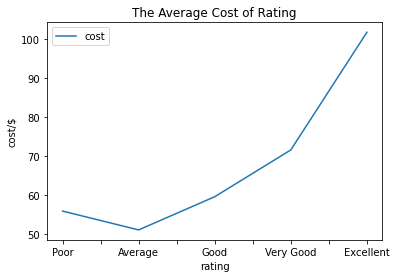

In [102]:
import matplotlib.pyplot as plt

df_1 = df[["rating_text","cost"]]

rating_order = ['Poor','Average', 'Good', 'Very Good','Excellent'] 
df_1.groupby(['rating_text']).mean().loc[rating_order].plot()

plt.xlabel('rating')
plt.ylabel('cost/$')
plt.title('The Average Cost of Rating')

plt.show()

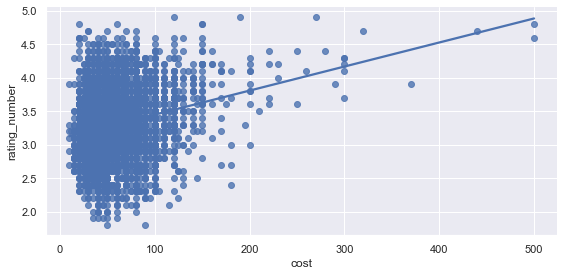

In [113]:
import seaborn as sns
#print bar graph
sns.lmplot(x='cost', y='rating_number', data=df, ci=None, height=4, aspect=8/4)


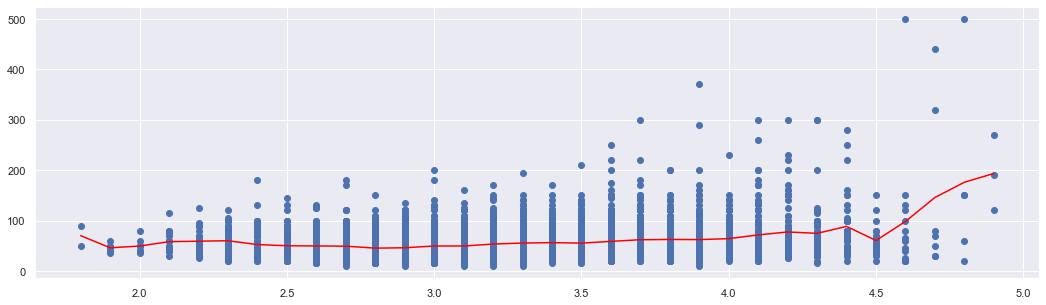

In [152]:
df_mean_rating = df.groupby(['rating_number'],as_index=False)['cost'].mean() #get the mean cost of each rating
plt.scatter('rating_number', 'cost', data=df) #scatter of rating and cost
plt.plot('rating_number', 'cost', color='red',data=df_mean_rating)
plt.show()

### 2. Plots/Graphs

In [155]:
df_2 = df[["rating_number","cost",'type']]

print(df_2.isna().sum()* 100 / len(df) ) # check the percentage of NA and print

df_2 = df_2[df_2['rating_number'].notna() & df_2['cost'].notna() & df_2['type'].notna() ] #remove NA values

df_2group = df_2.groupby(['type'],as_index=False).mean()

df_2group.columns

rating_number    31.580952
cost              3.295238
type              0.457143
dtype: float64


Index(['type', 'rating_number', 'cost'], dtype='object')

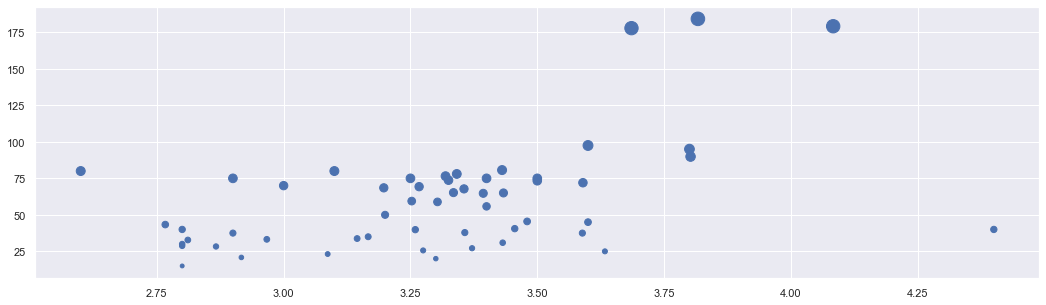

In [143]:
plt.scatter('rating_number', 'cost', s='cost', data=df_2group)

### 3. Produce  Cusine Density Map

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Reading data from the shape file
sydney_data = gpd.read_file('data/sydney.geojson')


print(sydney_data[:3])

sydney_data = sydney_data[['SSC_NAME','geometry']]

sydney_data.rename(columns = {'SSC_NAME':'subzone'},inplace = True)

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


  SSC_CODE          SSC_NAME CONF_VALUE      SQKM  \
0    10001        Abbotsbury  Very good  4.984673   
1    10002  Abbotsford (NSW)  Very good  1.017855   
2    10010    Acacia Gardens  Very good  0.946630   

                                            geometry  
0  POLYGON ((150.85118 -33.87069, 150.85104 -33.8...  
1  POLYGON ((151.12593 -33.84578, 151.12678 -33.8...  
2  POLYGON ((150.90781 -33.73547, 150.90799 -33.7...  


<AxesSubplot:>

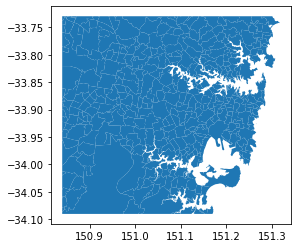

In [77]:
# plot sydney map
sydney_data.plot()

In [74]:
#reprojecting to prijected coordinate system
sydney_data_tr = sydney_data.to_crs(epsg = 3112)
sydney_data_tr['area'] = sydney_data.area

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_13700/3063680339.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sydney_data_tr['area'] = sydney_data.area


In [84]:
# transform Longitude and Latitude into a list of shapely.Point objects 
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))
df_geo = df_geo[['geometry','cuisine']]

df_geo = df_geo.set_crs(epsg=4326, inplace=True)
df_geo_tr = df_geo.to_crs(epsg=3112)

# Using spatial join affixes data from one feature layer's attribute table to another from a spatial perspective
mydata = gpd.sjoin(df_geo_tr, sydney_data_tr,how="inner")

<AxesSubplot:>

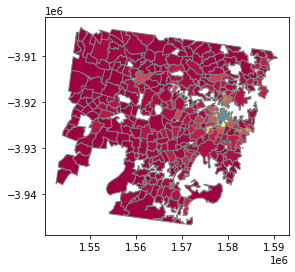

In [85]:
# count the number of restaurant in each subzone
mydata_2 = mydata.groupby(['subzone'], as_index = False)['area'].count()
mydata_2 = mydata_2.rename(columns={"area": "num_restaurant"})

#merge the number of restaurant with the map data
mydata_3 = sydney_data_tr.merge(mydata_2, on = 'subzone')
mydata_3['density'] = mydata_3['num_restaurant']/mydata_3['area']

#plotting the density of all kind of restrurant
mydata_3.plot(column = 'density', cmap = 'Spectral', edgecolor='grey')

In [93]:
def show_cuisine_densitymap(cuisine, mydata, sydney_data_tr):
    
    #filter rows
    mydata = mydata[mydata['cuisine'].str.contains(cuisine)]
    
    #count the number of the restaurant
    mydata_2 = mydata.groupby(['subzone'], as_index = False)['area'].count()
    mydata_2 = mydata_2.rename(columns={"area": "num_restaurant"})
    
    #merge data
    mydata_3 = sydney_data_tr.merge(mydata_2, on = 'subzone',how = 'outer')
    
    #caculate density
    mydata_3['density'] = mydata_3['num_restaurant']/mydata_3['area']
    
    return mydata_3.plot(column = 'density', cmap = 'Spectral', edgecolor='grey')
   

<AxesSubplot:>

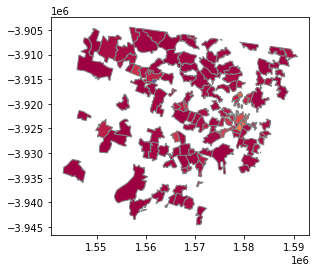

In [94]:
show_cuisine_densitymap(cuisine = 'Indian',mydata = mydata, sydney_data_tr = sydney_data_tr)

<AxesSubplot:>

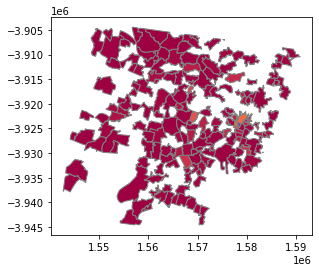

In [91]:
show_cuisine_densitymap(cuisine = 'Chinese',mydata = mydata, sydney_data_tr = sydney_data_tr)